In [ ]:
!pip install interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 104.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 34.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 

In [ ]:
!pip install h2o


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 MB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.40.0.4-py2.py3-none-any.whl size=177697886 sha256=794d7ca04a53dd2d9b3c1819ff654bd8a859a5432c8ed907b29685d03e8b93e4
  Stored in directory: /root/.cache/pip/wheels/43/f2/b0/5bb4d702a0467e82d77c45088db3eef25114c26b0eec8e7f6a
Successfully built h2o


In [ ]:

import h2o                                                        # h2o python library
from h2o.backend import H2OLocalServer                            # for model extraction
from h2o.estimators.random_forest import H2ORandomForestEstimator # for decision tree in model extraction
from interpret.glassbox import ExplainableBoostingClassifier      # interpret ebm class
from interpret.perf import ROC                                    # ROC measure for ebm
import matplotlib.pyplot as plt                                   # for plots
import numpy as np                                                # for basic array manipulation
import pandas as pd                                               # for dataframe manipulation
import subprocess                                                 # to run external processes for model extraction
import time                                                       # for timers

# enables display of images in notebook
from IPython.display import Image
from IPython.display import display

# set numpy random seed for better reproducibility
SEED = 12345
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='2G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.19" 2023-04-18; OpenJDK Runtime Environment (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2_oiampg
  JVM stdout: /tmp/tmp2_oiampg/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp2_oiampg/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 23 days
H2O_cluster_name:,H2O_from_python_unknownUser_94y3o5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Define Utility Functions

#### Utility function that trains a cross-validated decision tree

In [ ]:
def get_cv_dt(x_names, y_name, train, model_id, seed_, title, valid=None):

    """ Utility function to train decision trees.
    Args:
        x_names: Names of input variables as a list.
        y_name: Name of target variable.
        train: Pandas DataFrame containing x_names and y_name on which to train
               decision tree.
        model_id: h2o model identifier.
        seed_: Random seed for improved reproducibility.
        title: Title for generated plot of tree.
        valid: Optional validation data.
    Returns:
        Model as h2o model object.
    """

    # initialize single tree model
    tree = H2ORandomForestEstimator(ntrees=1,  # use only one tree
                                    sample_rate=1,  # use all rows in that tree
                                    mtries=-2,  # use all columns in that tree's split search
                                    max_depth=4,  # shallow trees are easier to understand
                                    seed=seed_,  # set random seed for reproducibility
                                    nfolds=3,  # cross-validation for stability and ...
                                    # only way to get metrics for 1 tree in h2o
                                    model_id=model_id)  # gives MOJO artifact a recognizable name

    # train single tree model
    if valid is not None:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train), validation_frame=h2o.H2OFrame(valid))
    else:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train))

    # persist MOJO (compiled Java representation of trained model)
    # from which to generate plot of tree
    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)

    # generate graphviz file and then PNG
    get_gv(title, model_id, mojo_path)
    get_png(model_id)

    return tree

#### Utility function that converts h2o MOJO into graphviz file

In [ ]:
def get_gv(title, model_id, mojo_path):

    """ Utility function to generate graphviz dot file from h2o MOJO using
        a subprocess.

    Args:
        title: Title for displayed decision tree.
        model_id: h2o model identifier.
        mojo_path: Path to saved model MOJO (Java scoring artifact);
                   generated by train_cv_dt function above.
    """

    # locate h2o jar
    hs = H2OLocalServer()
    h2o_jar_path = hs._find_jar()
    print('Discovered H2O jar path:\n', h2o_jar_path)

    # construct command line call to generate graphviz version of
    # tree, see for more information:
    # http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
    gv_file_name = model_id + '.gv'
    # if the line below fails for you, try instead:
    #gv_args = str('-cp ' + h2o_jar_path +
    #              ' hex.genmodel.tools.PrintMojo --tree 0 -i "'
    #              + mojo_path + '" -o').split()
    gv_args = str('-cp ' + h2o_jar_path +
                  ' hex.genmodel.tools.PrintMojo --tree 0 -i '
                  + mojo_path + ' -o').split()
    gv_args.insert(0, 'java')
    gv_args.append(gv_file_name)
    if title is not None:
        gv_args = gv_args + ['--title', '"' + str(title) + '"']

    # call constructed command
    print()
    print('Calling external process ...')
    print(' '.join(gv_args))
    # if the line below is failing for you, try instead:
    # _ = subprocess.call(gv_args, shell=True)
    _ = subprocess.call(gv_args)

#### Utility function that converts graphviz file into PNG

In [ ]:
def get_png(model_id):

    """ Utility function to generate PNGs from .dots using a subprocess.
    Arg:
        model_id: h2o model identifier.
    """

    gv_file_name = model_id + '.gv'

    # construct call to generate PNG from
    # graphviz representation of the tree
    png_file_name = model_id + '.png'
    png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
    png_args = png_args.split()

    # call
    print('Calling external process ...')
    print(' '.join(png_args))
    # if the line below is failing for you, try instead:
    # _ = subprocess.call(png_args, shell=True)
    _ = subprocess.call(png_args)

### Start global timer

In [ ]:
tic = time.time()

In [ ]:
## Import pandas and HMDA data as CSV

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hmda_train_preprocessed.csv to hmda_train_preprocessed.csv


### Import data

In [ ]:
data = pd.read_csv('hmda_train_preprocessed.csv')

### Assign basic modeling roles

In [ ]:
y_name = 'high_priced'

### Fit interpretable model

### Split data into train and validation partitions

In [ ]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Explainable Boosting Machine

In [ ]:
### Retrain most accurate model above 0.8 AIR to act as blackbox prediction API

In [ ]:
# params dict for remediated models
rem_params = {'max_bins': 256,
              'max_interaction_bins': 64,
              'interactions': 15,
              'outer_bags': 12,
              'inner_bags': 0,
              'learning_rate': 0.01,
              'validation_size': 0.5,
              'min_samples_leaf': 2,
              'max_leaves': 5,
              'early_stopping_rounds': 100.0,
              'n_jobs': 4,
              'random_state': 12345}

rem_x_names = ['debt_to_income_ratio_missing',
               'conforming',
               'intro_rate_period_std',
               'debt_to_income_ratio_std',
               'income_std',
               'term_360',
               'property_value_std']

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name])
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Remediated EBM retrained with AUC: 0.7809.


### Model Extraction Attack

### Generate synthetic data for extraction attack
For an API or model to be usable by customers or others, the system documentation must contain basic information about expected input variables. Between that information, domain knowledge, and publicly available information, an attacker can make a good guess at what the input data should look like.

In [ ]:
# best guess at feature distributions
schema_dict = {'term_360':                     {'p': 0.9, 'dist': 'binomial'},
               'conforming':                   {'p': 0.9, 'dist': 'binomial'},
               'intro_rate_period_std':        {'min': 0, 'scale': 2, 'dist': 'exponential'},
               'property_value_std':           {'min': -5, 'scale': 5, 'dist': 'exponential'},
               'income_std':                   {'min': -5, 'scale': 25, 'dist': 'exponential'},
               'debt_to_income_ratio_std':     {'mean': 1, 'scale': 1, 'dist': 'normal'},
               'debt_to_income_ratio_missing': {'mean': 1, 'scale': 1, 'dist': 'normal'}}

N = 10000 # rows of simulated data

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) # init empty frame

np.random.seed(SEED) # same results each time cell is run

for j in list(schema_dict.keys()): # loop through features

    # simulate normal features
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'],
                                           size=N)

    # simulate expontential features
    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'],
                                                                        size=N)

    # simulate binomial features
    if schema_dict[j]['dist'] == 'binomial':
        random_frame[j] = np.random.binomial(1, schema_dict[j]['p'], N)

# make up for no_intro_rate_period_std scale shift
random_frame['term_360'] = -4 * random_frame['term_360']

#### Visualize simulated data

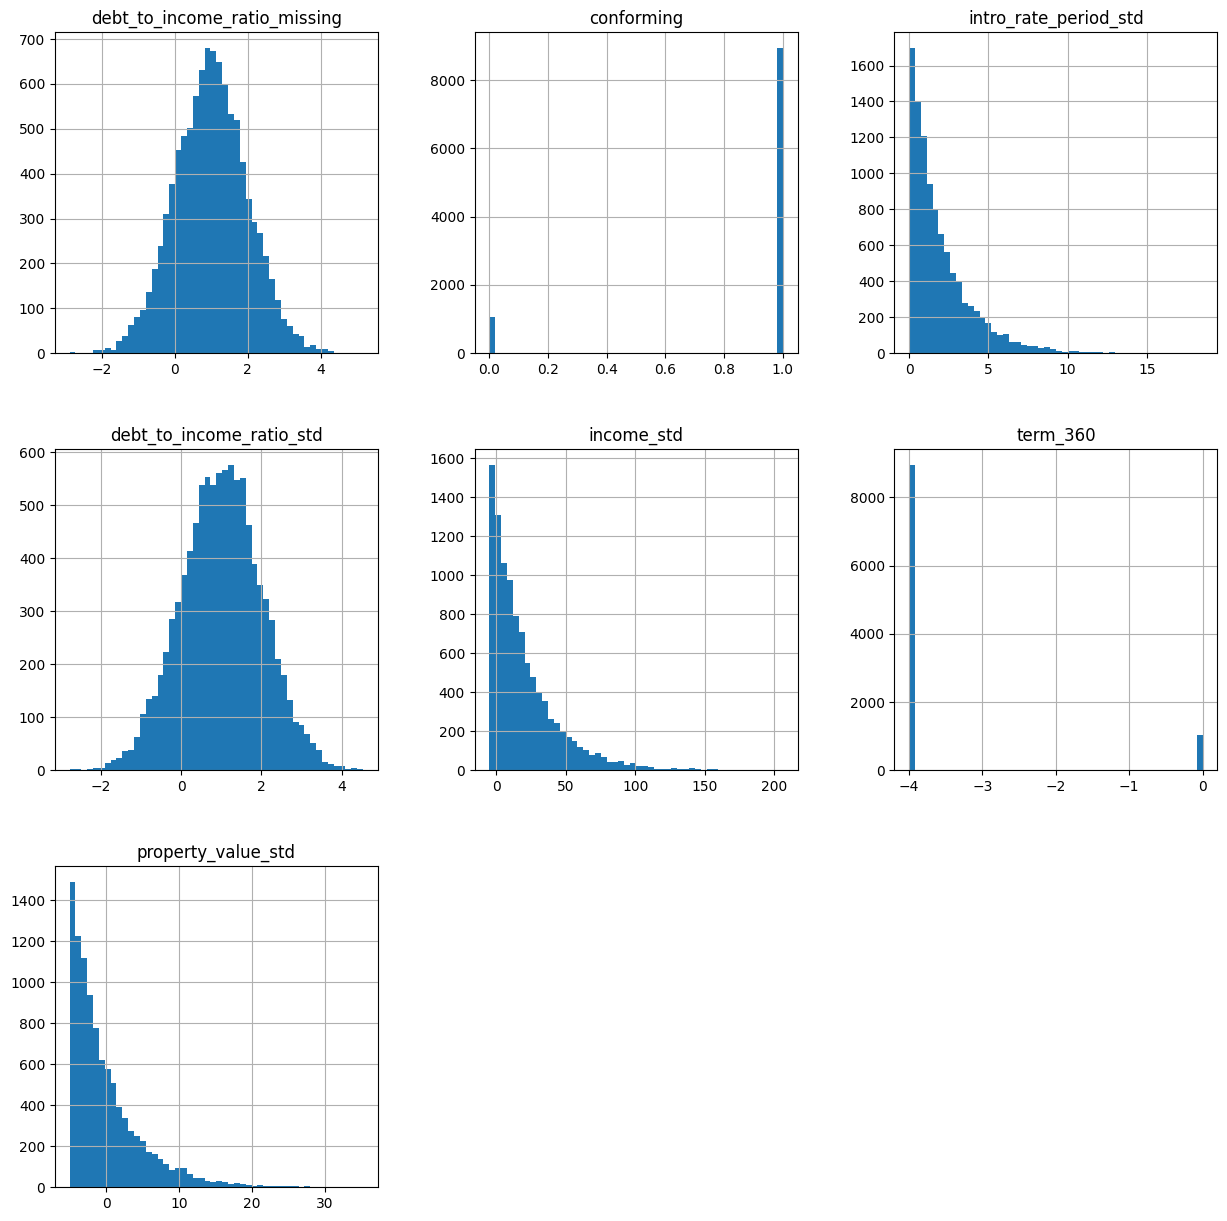

In [ ]:
_ = random_frame[rem_x_names].hist(bins=50, figsize=(15, 15))

#### First call to blackbox model for predictions on random data

In [ ]:
blackbox_phat = pd.DataFrame(rem_ebm.predict_proba(random_frame[rem_x_names])[:, 1], columns=['phat'])
blackbox_phat = pd.concat([random_frame.reset_index(drop=True), blackbox_phat], axis=1)
blackbox_phat.head()

,term_360,conforming,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,debt_to_income_ratio_missing,phat
0,0,1,0.047460,1.424353,20.226335,1.124646,1.834667,0.141299
1,-4,1,7.954180,22.240149,7.874433,1.123252,1.580080,0.005830
2,-4,1,3.762783,-2.492924,30.673523,2.683992,0.701477,0.001830
3,-4,1,0.100142,1.456200,-1.889726,-0.851652,1.515910,0.269861
4,-4,1,0.055818,-4.769201,17.451436,0.344748,0.339692,0.252853


In [ ]:
!pip install graphviz


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Extract a stolen decision tree model

In [ ]:
stolen_dt = get_cv_dt(list(schema_dict.keys()),
                      'phat',
                      blackbox_phat,
                      'stolen_dt',
                      SEED,
                      'Stolen Model')



Generated MOJO path:
 /content/stolen_dt.zip
Discovered H2O jar path:
 /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /content/stolen_dt.zip -o stolen_dt.gv --title "Stolen Model"
Calling external process ...
dot -Tpng stolen_dt.gv -o stolen_dt.png


### View stolen model

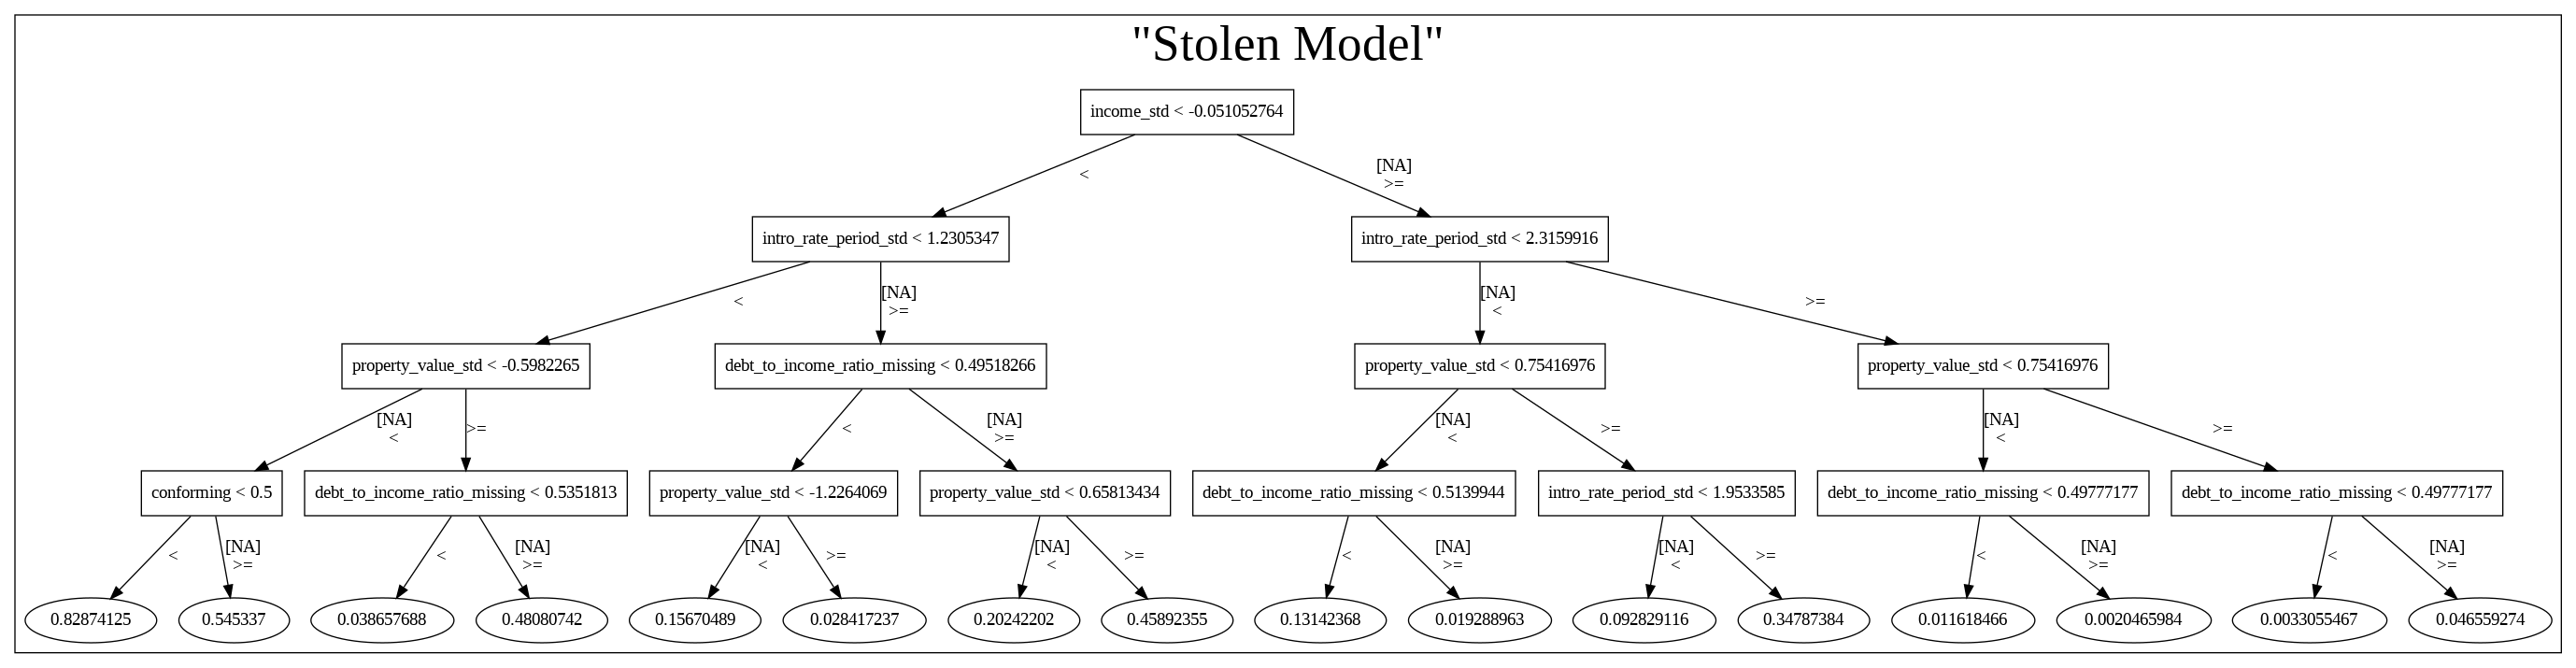

In [ ]:
display(Image(('stolen_dt.png')))

#### Double clicking should zoom.

### Variable importance for stolen model

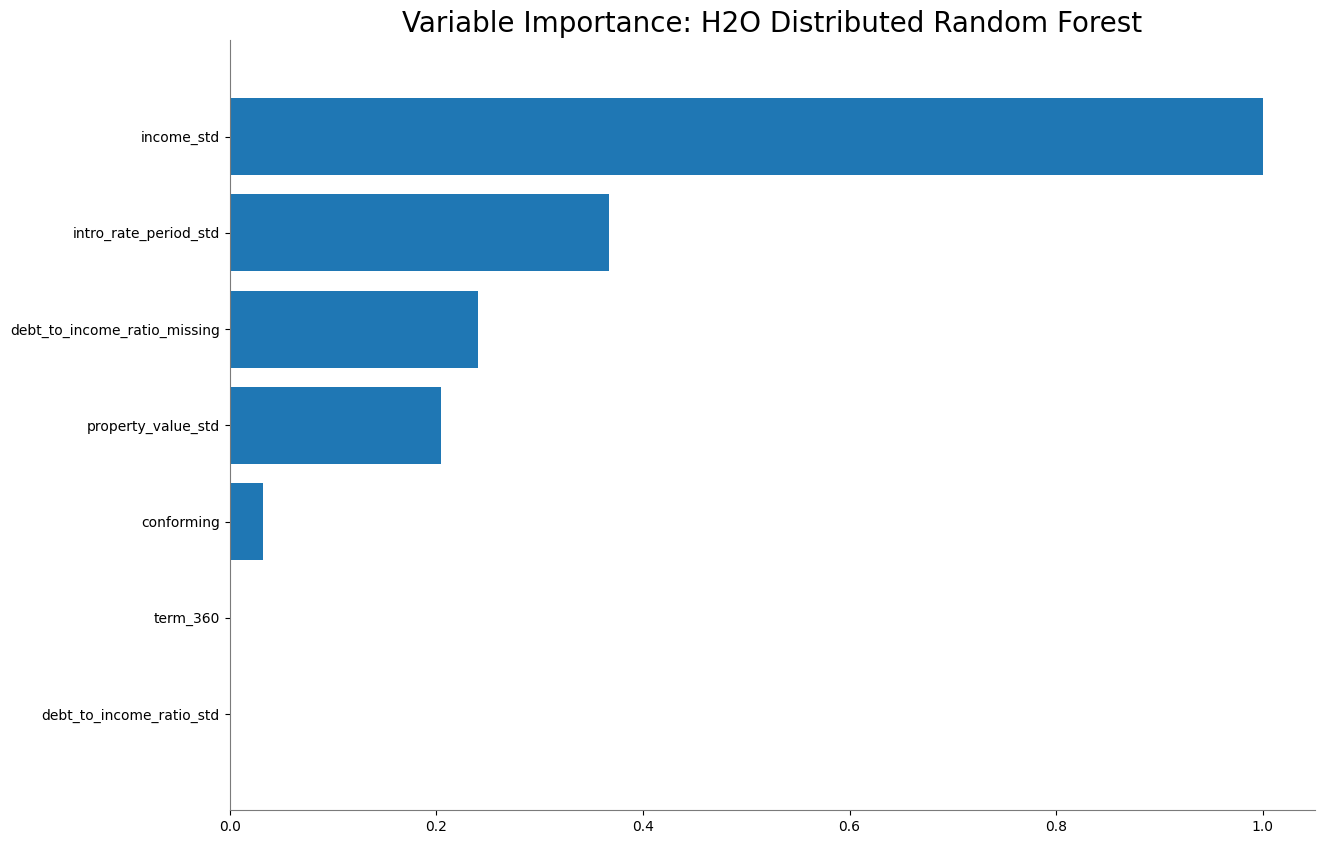

<Figure size 640x480 with 0 Axes>

In [ ]:
stolen_dt.varimp_plot()

### Assess accuracy of stolen model

In [ ]:
stolen_dt.cross_validation_metrics_summary() # h2o makes cv evaluation metrics available

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0595886,0.0040309,0.0641362,0.0564560,0.0581735
mean_residual_deviance,0.0105925,0.0014507,0.0110550,0.0089669,0.0117556
mse,0.0105925,0.0014507,0.0110550,0.0089669,0.0117556
r2,0.6837521,0.0342411,0.6616598,0.7231954,0.6664010
residual_deviance,0.0105925,0.0014507,0.0110550,0.0089669,0.0117556
rmse,0.1027533,0.0071698,0.1051427,0.0946938,0.1084233
rmsle,0.0793920,0.0047553,0.0819067,0.0739073,0.0823618


#### he stolen model is accurate enough (R2=0.68, RMSE=0.10275), and importantly, very stable.

### Use Stolen Model to Craft Adversarial Examples

### Use stolen model to find seed rows for adversary searches

In [ ]:
low_adversary_seed = random_frame.loc[(random_frame['income_std'] >= -0.051) &
                                      (random_frame['intro_rate_period_std'] >= 2.315) &
                                      (random_frame['property_value_std'] <= 0.754)&
                                      (random_frame['debt_to_income_ratio_missing'] >= 0.497),:].mean()
print('Low adversarial example search seed row:')
print(low_adversary_seed)
print()

high_adversary_seed = random_frame.loc[(random_frame['income_std']  < -0.051) &
                                       (random_frame['intro_rate_period_std'] <1.23) &
                                       (random_frame['property_value_std'] <= -0.598) &
                                       (random_frame['conforming'] < 0.5),:].mean()

print('High adversarial example search seed row:')
print(high_adversary_seed)

Low adversarial example search seed row:
term_360                        -3.559265
conforming                       0.893155
intro_rate_period_std            4.296526
property_value_std              -2.673280
income_std                      25.210695
debt_to_income_ratio_std         1.045548
debt_to_income_ratio_missing     1.516903
dtype: float64

High adversarial example search seed row:
term_360                       -3.448276
conforming                      0.000000
intro_rate_period_std           0.538119
property_value_std             -3.077957
income_std                     -2.791624
debt_to_income_ratio_std        1.122342
debt_to_income_ratio_missing    1.041847
dtype: float64


### Perturb seed row to find low scoring adversarial examples

In [ ]:
# init results frames
low_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys()))

# quantiles over which to search
low_quantiles = [0.01, 0.05, 0.1, 0.25, 0.5]
high_quantiles = [0.99, 0.95, 0.9, 0.75, 0.5]

# generate potential adversarial examples across four important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['income_std'].quantile(high_quantiles)):
        for b in list(random_frame['intro_rate_period_std'].quantile(high_quantiles)):
            for c in list(random_frame['property_value_std'].quantile(low_quantiles)):
                for d in list(random_frame['debt_to_income_ratio_missing'].quantile(low_quantiles)):
                    low_adversary_seed['income_std'] = a
                    low_adversary_seed['intro_rate_period_std'] = b
                    low_adversary_seed['property_value_std'] = c
                    low_adversary_seed['debt_to_income_ratio_missing'] = d
                    low_adversary_frame = low_adversary_frame.append(low_adversary_seed,
                                                                     ignore_index=True, sort=False)

# view potential low scoring adversarial examples
low_adversary_frame.head()

,term_360,conforming,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,debt_to_income_ratio_missing
0,-3.559265,0.893155,9.085445,-4.947597,108.369745,1.045548,-1.282362
1,-3.559265,0.893155,9.085445,-4.947597,108.369745,1.045548,-0.612534
2,-3.559265,0.893155,9.085445,-4.947597,108.369745,1.045548,-0.263293
3,-3.559265,0.893155,9.085445,-4.947597,108.369745,1.045548,0.324928
4,-3.559265,0.893155,9.085445,-4.947597,108.369745,1.045548,0.999670


#### Perturb seed row to find high scoring adversarial examples

In [ ]:
# init results frames
high_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys()))

# generate potential adversarial examples across four important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['income_std'].quantile(low_quantiles)):
        for b in list(random_frame['intro_rate_period_std'].quantile(low_quantiles)):
            for c in list(random_frame['property_value_std'].quantile(high_quantiles)):
                for d in list(random_frame['conforming'].quantile(high_quantiles)):
                    high_adversary_seed['income_std'] = a
                    high_adversary_seed['intro_rate_period_std'] = b
                    high_adversary_seed['property_value_std'] = c
                    high_adversary_seed['conforming'] = d
                    high_adversary_frame = high_adversary_frame.append(high_adversary_seed,
                                                                       ignore_index=True, sort=False)

# view potential high scoring adversarial examples
high_adversary_frame.head()

,term_360,conforming,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,debt_to_income_ratio_missing
0,-3.448276,1.0,0.022874,18.137701,-4.772813,1.122342,1.041847
1,-3.448276,1.0,0.022874,18.137701,-4.772813,1.122342,1.041847
2,-3.448276,1.0,0.022874,18.137701,-4.772813,1.122342,1.041847
3,-3.448276,1.0,0.022874,18.137701,-4.772813,1.122342,1.041847
4,-3.448276,1.0,0.022874,18.137701,-4.772813,1.122342,1.041847


#### Second call to blackbox API to test adversarial examples

In [ ]:
# combine potential adversaries so only one call to API is needed
adversaries = pd.concat([low_adversary_frame, high_adversary_frame], axis=0)

# score potential adversarial examples to understand their effect on generated predictions
blackbox_adversaries_phat = pd.DataFrame(rem_ebm.predict_proba(adversaries[rem_x_names])[:, 1], columns=['phat'])
blackbox_adversaries_phat = pd.concat([adversaries.reset_index(drop=True), blackbox_adversaries_phat], axis=1)
blackbox_adversaries_phat.sort_values(by='phat')

,term_360,conforming,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,debt_to_income_ratio_missing,phat
129,-3.559265,0.893155,9.085445,-4.947597,70.667277,1.045548,0.999670,0.000221
509,-3.559265,0.893155,9.085445,-4.742531,12.295293,1.045548,0.999670,0.000221
274,-3.559265,0.893155,9.085445,-1.548983,52.600005,1.045548,0.999670,0.000221
269,-3.559265,0.893155,9.085445,-3.533041,52.600005,1.045548,0.999670,0.000221
264,-3.559265,0.893155,9.085445,-4.493164,52.600005,1.045548,0.999670,0.000221
...,...,...,...,...,...,...,...,...
693,-3.448276,1.000000,0.208170,1.957159,-4.772813,1.122342,1.041847,0.587382
969,-3.448276,1.000000,0.573009,1.957159,-2.397892,1.122342,1.041847,0.587382
694,-3.448276,1.000000,0.208170,1.957159,-4.772813,1.122342,1.041847,0.587382
966,-3.448276,1.000000,0.573009,1.957159,-2.397892,1.122342,1.041847,0.587382


#### We now have many adversarial examples that can reliably evoke extremely low and high enough predictions from the blackbox API (0.58 is likely above the cutoff for most credit models.). These can most easily be used to falsify a loan application to recieve a low-priced loan (using low adversaries). Or they could be used to ensure someone else recievces a high-priced loan.

### End timer

In [ ]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 675.34 s.


In [ ]:
### Shutdown H2O

In [ ]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_ba58 closed.
